ANOVA and OLS Regression
========================
This notebook combines school demographic data
and New York State ELA test scores to examine
the factors that predict test scores. In it we
run a t-test to test for statistic difference
in the scores for White students and Black students.

We then run analysis of variance between the 4
main ethnic/racial groups to see if there is statistical
significance in the outcomes. We run an OLS regression
on these groups with the "All Students" as a baseline
reference category and display the ANOVA table and regression summary.

Finally, one run a different OLS regression to examine
the school demographic factors and their effect on test scores.

In [1]:
# automatically reload changes we make to schools.py and ui.py
%load_ext autoreload
%autoreload 2

In [2]:
# load the demographic data
import pandas as pd
import numpy as np
import scipy as scipy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

from IPython.display import Markdown as md

import schools
import ui

In [3]:
# load the demographic data and merge it with the ELA data
df = schools.load_school_demographics()

# load the data from the csv file
ela = pd.read_csv("ela-combined.csv")


#drop the rows with NaN (where the pop is too small to report)
ela = ela[ela["mean_scale_score"].notnull()]
df = df.merge(ela, how="inner", on=["dbn", "year"])

# show the columns in our merged data set
df.columns

Index(['dbn', 'district', 'boro', 'school_name', 'year', 'total_enrollment',
       'grade_3k_pk_half_day_full', 'grade_k', 'grade_1', 'grade_2', 'grade_3',
       'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'female_n', 'female_pct', 'male_n',
       'male_pct', 'asian_n', 'asian_pct', 'black_n', 'black_pct',
       'hispanic_n', 'hispanic_pct', 'multi_racial_n', 'multi_racial_pct',
       'native_american_n', 'native_american_pct', 'white_n', 'white_pct',
       'missing_race_ethnicity_data_n', 'missing_race_ethnicity_data_pct',
       'swd_n', 'swd_pct', 'ell_n', 'ell_pct', 'poverty_n', 'poverty_pct',
       'eni_pct', 'grade', 'category', 'number_tested', 'mean_scale_score',
       'level_1', 'level_1_pct', 'level_2', 'level_2_pct', 'level_3',
       'level_3_pct', 'level_4', 'level_4_pct', 'level_3_4', 'level_3_4_pct'],
      dtype='object')

In [4]:
# for this analysis we will only look at grade 8 scores for the 2018-19 school year
# the last pre-covid year
df = df[df["grade"] =='8']
df = df[df["year"] == 2019]

# create 5 groups as independent data frames

all_students = df[df["category"] == "All Students"][["dbn", "mean_scale_score"]]
black = df[df["category"] == "Black"][["dbn", "mean_scale_score"]]
white = df[df["category"] == "White"][["dbn", "mean_scale_score"]]
hispanic = df[df["category"] == "Hispanic"][["dbn", "mean_scale_score"]]
asian = df[df["category"] == "Asian"][["dbn", "mean_scale_score"]]


In [5]:
# calculate the mean test score and standard deviation for each group
mean_std = df.groupby('category').agg(Mean=('mean_scale_score', np.mean), STD=('mean_scale_score', np.std))
display(md("**Mean average and standard deviation of test scores for each group.**"))
display(mean_std)


# run a t-test to see if there is a statistical difference between white and black student scores
t = scipy.stats.ttest_ind(white["mean_scale_score"],black["mean_scale_score"])

display(md(f"""
**T-Test results** comparing school averages of 
White (`n={white["dbn"].count()}`) and Black (`n={black["dbn"].count()}`)
students in 8th grade student ELA scores for 2019-20 academic year.

- White students: M={white["mean_scale_score"].mean()}, SD={white["mean_scale_score"].std()}
- Black students: M={black["mean_scale_score"].mean()}, SD={black["mean_scale_score"].std()}
- T-score: {round(t.statistic, 4)}, p-val: {round(t.pvalue, 4)}

`n` values report the number of schools observed, not the number of test takers. Further analysis
will report on the t-test for weighted means that account for school size.
"""))

**Mean average and standard deviation of test scores for each group.**

,Mean,STD
category,,
All Students,600.919888,9.352696
Asian,610.558379,9.357716
Black,598.167014,7.726598
Current ELL,577.973401,6.288727
Econ Disadv,601.111595,8.710385
Ever ELL,604.205822,6.341045
Female,603.969318,9.035509
Hispanic,598.650780,8.181750
Male,597.865757,9.571399



**T-Test results** comparing school averages of 
White (`n=176`) and Black (`n=318`)
students in 8th grade student ELA scores for 2019-20 academic year.

- White students: M=608.2399111659091, SD=10.524117180693764
- Black students: M=598.1670142591196, SD=7.7265981679485085
- T-score: 12.1507, p-val: 0.0

`n` values report the number of schools observed, not the number of test takers. Further analysis
will report on the t-test for weighted means that account for school size.


In [6]:
# run a one way anova to test if there is significant difference between the
# average test scores at the school level of 4 different racial/ethnic groups

fvalue, pvalue = scipy.stats.f_oneway(
    asian["mean_scale_score"], 
    black["mean_scale_score"],
    hispanic["mean_scale_score"],
    white["mean_scale_score"])


results = f"""
A **one-way between subjects ANOVA** was conducted to compare the effect of 
racial/ethnic group on the test score for 8th grade NYS ELA exams for
Asian (n={len(asian)}), Black (n={len(black)}), Latinx (n={len(hispanic)}),
and White (n={len(white)}) students.

The was a significant effect of racial/ethnic group on test score at
the p<.001 level for the four conditions., [p={pvalue}, F={round(fvalue,3)}]
"""
md(results)


A **one-way between subjects ANOVA** was conducted to compare the effect of 
racial/ethnic group on the test score for 8th grade NYS ELA exams for
Asian (n=169), Black (n=318), Latinx (n=374),
and White (n=176) students.

The was a significant effect of racial/ethnic group on test score at
the p<.001 level for the four conditions., [p=1.2920393648289998e-68, F=124.039]


In [7]:
# run OLS regression on the different category of test scores
model = ols('mean_scale_score ~ C(category, Treatment(reference="All Students"))', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(md("### OLS Model Summary: Demographic Group Test Scores Regression"))
display(model.summary())
display(md("**ANOVA Table**"))
anova_table

### OLS Model Summary: Demographic Group Test Scores Regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       mean_scale_score   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     249.3
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:55:41   Log-Likelihood:                -17569.
No. Observations:                4919   AIC:                         3.517e+04
Df Residuals:                    4905   BIC:                         3.526e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             600.9199      0.398   1508.033      0.000     600.139     601.701
C(category, Treatment(reference="All Students"))[T.Asian]               9.6385      0.774     12.459      0.000       8.122      11.155
C(category, Treatment(reference="All Students"))[T.Black]              -2.7529      0.626     -4.394      0.000      -3.981      -1.525
C(category, Treatment(reference="All Students"))[T.Current ELL]       -22.9465      0.692    -33.152      0.000     -24.303     -21.590
C(category, Treatment(reference="All Students"))[T.Econ Disadv]         0.1917      0.594      0.323      0.747      -0.974       1.357
C(category, Treatment(reference="All Students"))[T.Ever ELL]            3.2859      0.671      4.897      0.000       1.971       4.601
C(category, Treatment(reference="All Students"))[T.Female]              3.0494      0.568      5.364      0.000       1.935       4.164
C(category, Treatment(reference="All Students"))[T.Hispanic]           -2.2691      0.598     -3.795      0.000      -3.441      -1.097
C(category, Treatment(reference="All Students"))[T.Male]               -3.0541      0.569     -5.366      0.000      -4.170      -1.938
C(category, Treatment(reference="All Students"))[T.Never ELL]           1.1968      0.576      2.080      0.038       0.069       2.325
C(category, Treatment(reference="All Students"))[T.Not Econ Disadv]     4.5223      0.598      7.564      0.000       3.350       5.694
C(category, Treatment(reference="All Students"))[T.Not SWD]             2.3231      0.578      4.019      0.000       1.190       3.456
C(category, Treatment(reference="All Students"))[T.SWD]               -13.3473      0.582    -22.948      0.000     -14.488     -12.207
C(category, Treatment(reference="All Students"))[T.White]               7.3200      0.762      9.603      0.000       5.826       8.814
==============================================================================
Omnibus:                      223.023   Durbin-Watson:                   0.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.244
Skew:                           0.417   Prob(JB):                     1.94e-72
Kurtosis:                       3.957   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**ANOVA Table**

,sum_sq,df,F,PR(>F)
"C(category, Treatment(reference=""All Students""))",240840.943761,13.0,249.304265,0.0
Residual,364498.941506,4905.0,NaN,NaN


In [8]:
# run different OLS regression using the school demographics to predict mean_scale_score for all students
# the above example uses the R-like formual method for OLS
# this uses the python/programmatic approach

# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct',  'black_pct', 
       'hispanic_pct',  'white_pct','swd_pct',  'ell_pct',  'poverty_pct']

# only use the All Students data
data = df[df["category"]=="All Students"].copy()

# add boro as a factor, but convert to category first
# "dummies" basically converts the categorical boro data to "wide" Bolean data with one col for reach boro
dummies = pd.get_dummies(data[['boro']])

display(md("### OLS Model Summary: School Demographics Regression"))

y = data['mean_scale_score']
# boros are not adding information, leave them out
# X = pd.concat([data[factors], dummies], axis=1)
X = data[factors]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

display(model.summary())
display(model.summary2())

### OLS Model Summary: School Demographics Regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       mean_scale_score   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     143.7
Date:                Fri, 25 Mar 2022   Prob (F-statistic):          7.89e-120
Time:                        13:55:51   Log-Likelihood:                -1416.4
No. Observations:                 468   AIC:                             2851.
Df Residuals:                     459   BIC:                             2888.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              620.8356     11.122     55.823      0.000     598.980     642.691
total_enrollment    -0.0019      0.001     -2.418      0.016      -0.003      -0.000
asian_pct           12.6637     12.764      0.992      0.322     -12.420      37.747
black_pct           -3.3355     12.570     -0.265      0.791     -28.038      21.367
hispanic_pct         3.8469     12.382      0.311      0.756     -20.486      28.180
white_pct            7.8307     12.093      0.648      0.518     -15.933      31.595
swd_pct            -43.5235      4.309    -10.100      0.000     -51.992     -35.055
ell_pct            -35.6335      2.814    -12.661      0.000     -41.164     -30.103
poverty_pct        -10.0910      2.799     -3.605      0.000     -15.592      -4.590
==============================================================================
Omnibus:                       18.158   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.857
Skew:                           0.103   Prob(JB):                     8.14e-10
Kurtosis:                       4.451   Cond. No.                     8.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:                OLS              Adj. R-squared:     0.710    
Dependent Variable:   mean_scale_score AIC:                2850.8548
Date:                 2022-03-25 13:55 BIC:                2888.1910
No. Observations:     468              Log-Likelihood:     -1416.4  
Df Model:             8                F-statistic:        143.7    
Df Residuals:         459              Prob (F-statistic): 7.89e-120
R-squared:            0.715            Scale:              25.397   
--------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------
const            620.8356  11.1216  55.8226 0.0000 598.9801 642.6912
total_enrollment  -0.0019   0.0008  -2.4180 0.0160  -0.0034  -0.0004
asian_pct         12.6637  12.7641   0.9921 0.3217 -12.4197  37.7471
black_pct         -3.3355  12.5704  -0.2653 0.7909 -28.0380  21.3671
hispanic_pct       3.8469  12.3823   0.3107 0.7562 -20.4861  28.1799
white_pct          7.8307  12.0927   0.6476 0.5176 -15.9331  31.5945
swd_pct          -43.5235   4.3092 -10.1002 0.0000 -51.9916 -35.0554
ell_pct          -35.6335   2.8143 -12.6615 0.0000 -41.1640 -30.1029
poverty_pct      -10.0910   2.7993  -3.6048 0.0003 -15.5921  -4.5899
--------------------------------------------------------------------
Omnibus:               18.158        Durbin-Watson:           1.737 
Prob(Omnibus):         0.000         Jarque-Bera (JB):        41.857
Skew:                  0.103         Prob(JB):                0.000 
Kurtosis:              4.451         Condition No.:           85621 
====================================================================
* The condition number is large (9e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

In [22]:
coeff = model.conf_int()
pd.DataFrame({"parameters": list(coeff.index), "coefficient":model.params})

coef_df = pd.DataFrame({
    'parameter': model.params.index.values[1:],
    'coef': model.params.values[1:],
    'pvalue': model.pvalues.round(4).values[1:]
})

coef_df["area"] = abs(coef_df["coef"])
coef_df["area_size"] = 300 * (abs(coef_df["coef"]) / coef_df.area.max())
coef_df

,parameter,coef,pvalue,area,area_size
0,total_enrollment,-0.001883,0.0160,0.001883,0.012978
1,asian_pct,12.663715,0.3217,12.663715,87.288782
2,black_pct,-3.335450,0.7909,3.335450,22.990677
3,hispanic_pct,3.846892,0.7562,3.846892,26.515958
4,white_pct,7.830703,0.5176,7.830703,53.975670
5,swd_pct,-43.523514,0.0000,43.523514,300.000000
6,ell_pct,-35.633465,0.0000,35.633465,245.615270
7,poverty_pct,-10.091042,0.0003,10.091042,69.555798


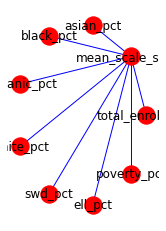

In [59]:
import networkx as nx
score = "mean_scale_score"
G = nx.Graph()
edges = zip(coef_df.parameter, ["mean_scale_score" for _ in range(len(coef_df))], coef_df.coef)
edges = tuple(edges)
G.add_weighted_edges_from(edges)
# G.add_edges_from([(1, 2), (1, 3)])
coef_df.apply(add_node, axis=1)
       # adds node "spam"
subax1 = plt.subplot(121)
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_color='r', edge_color='b')
plt.show()  


In [58]:

edges

(('total_enrollment', 'mean_scale_score', -0.0018828677355150827),
 ('asian_pct', 'mean_scale_score', 12.663714929032722),
 ('black_pct', 'mean_scale_score', -3.3354500802995517),
 ('hispanic_pct', 'mean_scale_score', 3.8468922326278516),
 ('white_pct', 'mean_scale_score', 7.830702625663207),
 ('swd_pct', 'mean_scale_score', -43.523513556553596),
 ('ell_pct', 'mean_scale_score', -35.63346504040055),
 ('poverty_pct', 'mean_scale_score', -10.091042394451847))

In [ ]:
a